In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd



In [2]:
class EDAFeatureSelection:
    def __init__(self, X, Y, popsize=100, NGenerations=10):
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
        self.model = ExtraTreesRegressor()
        self.Nfeatures = X.shape[1]
        self.popsize = popsize
        self.NGenerations = NGenerations
        self.population = np.zeros((self.popsize, self.Nfeatures), int)
        self.fitness = np.zeros((self.popsize))
        self.elite = np.zeros((self.Nfeatures), int)
        self.eliteFit = None

    def init_population(self):
        self.population = np.random.randint(0, 2, size=(self.popsize, self.Nfeatures))
        self.fitness = np.array([self.fitness_individual(i) for i in self.population])

    def fitness_individual(self, ind):
        self.model.fit(self.X_train[:, ind == 1], self.Y_train)
        Ypred = self.model.predict(self.X_test[:, ind == 1])
        return r2_score(self.Y_test, Ypred)

    def update_elite(self):
        i = np.argmax(self.fitness)
        if self.eliteFit is None or self.fitness[i] > self.eliteFit:
            self.elite = np.copy(self.population[i])
            self.eliteFit = self.fitness[i]
        else:
            i = np.random.randint(self.popsize)
            self.population[i] = self.elite
            self.fitness[i] = self.eliteFit

    def update_population(self):
        indices = np.argsort(self.fitness)[::-1][:self.popsize // 2]
        bestPop = self.population[indices]
        probs = np.mean(bestPop, axis=0)
        newPopulation = np.array([[1 if np.random.rand() <= i else 0 for i in probs] for _ in range(self.popsize // 2)])
        self.population[0:self.popsize // 2] = bestPop
        self.population[self.popsize // 2:] = newPopulation

    def plot_results(self, allPopulation, allFitness):
        features_used = [np.sum(i) for i in allPopulation]
        plt.figure(figsize=(10, 6))
        plt.scatter(allFitness, features_used, color='blue', marker='o')
        plt.xlabel('Fitness (R2 Score)')
        plt.ylabel('Number of Features Used')
        plt.title('Feature Selection with EDA')
        plt.grid(True)
        plt.show()

    def exec(self):
        self.init_population()
        allPopulation = []
        allFitness = []
        for generation in range(self.NGenerations):
            self.update_population()
            self.fitness = np.array([self.fitness_individual(ind) for ind in self.population])
            self.update_elite()
            allPopulation.append(self.population.copy())
            allFitness.append(self.fitness.copy())
            print(f'Generation {generation}, Best Fitness: {self.eliteFit}')

        allPopulation = np.vstack(allPopulation)
        allFitness = np.hstack(allFitness)
        self.plot_results(allPopulation, allFitness)

        return self.elite, self.eliteFit


Generation 0, Best Fitness: 0.6639676904836264
Generation 1, Best Fitness: 0.6639676904836264
Generation 2, Best Fitness: 0.6675803565297378
Generation 3, Best Fitness: 0.6675803565297378
Generation 4, Best Fitness: 0.6685429687844078
Generation 5, Best Fitness: 0.6685429687844078
Generation 6, Best Fitness: 0.6711942779584694
Generation 7, Best Fitness: 0.6733500606467377
Generation 8, Best Fitness: 0.673704250574794
Generation 9, Best Fitness: 0.673704250574794


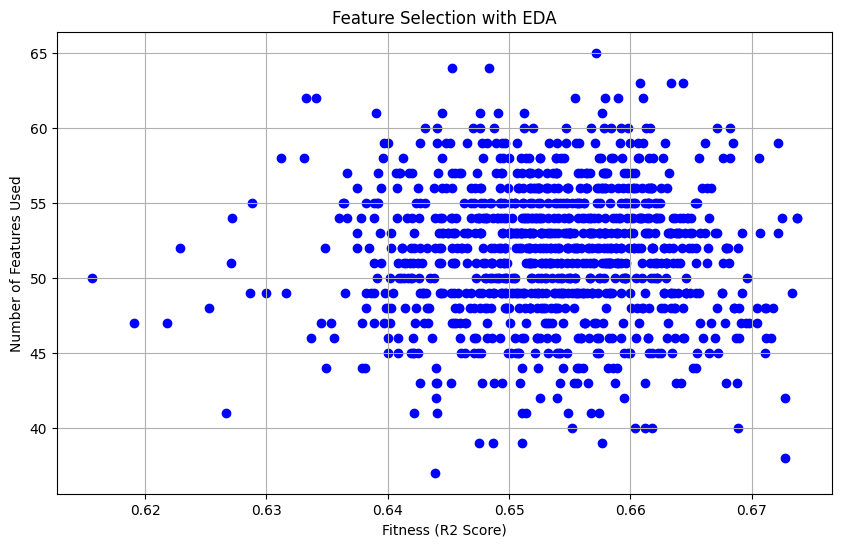

Mejor conjunto de características: [0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1
 1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0
 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0]
Mejor fitness (R2 Score): 0.673704250574794


In [3]:
# Cargar datos
df = pd.read_csv('communities_crime.csv')
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values

# Inicializar y ejecutar el EDA
eda = EDAFeatureSelection(X, Y, popsize=100, NGenerations=10)
mejor_individuo, mejor_fitness = eda.exec()

print('Mejor conjunto de características:', mejor_individuo)
print('Mejor fitness (R2 Score):', mejor_fitness)
